In [60]:
import os
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from mne_bids import BIDSPath, find_matching_paths, make_report, print_dir_tree, read_raw_bids
from scipy.stats import ttest_rel


In [2]:
print('MNE–Python version', mne.__version__)
print('MNE–BIDS version', mne_bids.__version__)

MNE–Python version 1.9.0
MNE–BIDS version 0.16.0


### define inputs

In [3]:

# on MBA local (copied from Sharepoint)
bids_root = os.path.join('/Users/dsj3886/data_local/',
                        'EAM1_local/data-bids')


In [13]:
# outputs
deriv_dir = os.path.join(bids_root, 'derivatives', 'cortical_filtered')



# Combine multiple runs (BIDS)

In [5]:
task_list = ['active', 'passive']

In [21]:
bl_start = 0.100
l_freq = 1
h_freq = 30

In [ ]:

for sub_num in range(2, 35):
    sub_label = f'{sub_num:02d}'
    '''
    if int(sub_label) > 19:
        event_mapping = {1:'passive/pos',
                        2:'passive/neg',
                        3:'active/pos',
                        4:'active/neg'}
    elif int(sub_label) > 13:
        event_mapping = {1:'pos',
                         2:'neg'}
    else:
        event_mapping = {2049:'pos',
                         2050:'neg'}
    '''
    # initialize an empty dictionary for data
    task_evoked_dict = {}
    event_evoked_dict = {}

    for task_label in task_list:
        print(f'Loading {task_label} data')

        epoch_list = []

        for run_label in range(1,6):
        # load in EEG data
            bids_path = BIDSPath(root=bids_root, datatype='eeg', 
                                 subject=str(sub_label), 
                                 task=task_label, 
                                 run=run_label)
            
            try:
                data = read_raw_bids(bids_path)
                data.load_data()

                # re-reference data to linked mastoid reference
                data_ref = data.set_eeg_reference(ref_channels=['M1', 'M2'])
                
                # filter data
                data_filtered = data_ref.copy().filter(l_freq=l_freq, h_freq=h_freq)


                # loading events from the stim-track-generated events
                events_fpath = sorted(glob(os.path.join(deriv_dir, 'events-stimtrack') + 
                        f'/*{sub_label}*{task_label}*{run_label}_stimtrack_events.tsv'))[0]
                events_df = pd.read_csv(events_fpath, delimiter='\t') 
                annot = mne.Annotations(onset=events_df.onset, duration=0.170, description=events_df.type)
                data_filtered.set_annotations(annot)
                events_from_annot, event_dict2 = mne.events_from_annotations(data_filtered)
                
                # epoch data based on stimulus events
                epochs = mne.Epochs(data_filtered, 
                                    events=events_from_annot, #events, 
                                    event_id=event_dict2, #event_dict,
                                    on_missing='warn',
                                    picks=['Cz'],
                                    tmin=-1*bl_start, tmax=0.4, 
                                    baseline=[-1*bl_start, 0],
                                    reject=dict(eeg=75e-6)).drop_bad()
                
                epoch_list.append(epochs)

            except:
                print(f"No run {run_label} for task-{task_label}")
        
        try:
            # combine epochs across runs
            all_epochs = mne.concatenate_epochs(epoch_list)
        except IndexError:
            print(f'cannot run for sub-{sub_label} task-{task_label} run-{run_label}')

        try:
            out_base = f'sub-{sub_label}_task-{task_label}_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif'
            all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
        except:
            continue


# Combine participants

In [22]:
sorted(glob(deriv_dir+f'/*baseline-{bl_start}_*filt-{l_freq}-{h_freq}*stim*fif'))

['/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-02_task-active_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-02_task-passive_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-03_task-active_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-03_task-passive_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-04_task-active_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-04_task-passive_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/

In [23]:
act_pos_avgs = []
act_neg_avgs = []
act_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-active_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif') for sub_num in range(2,35))]
for act_ep in act_eps[0]:
    try:
        sub_active_epochs = mne.read_epochs(act_ep[0], verbose='WARNING')
        act_pos_avgs.append(sub_active_epochs['1'].average())
        act_neg_avgs.append(sub_active_epochs['2'].average())
    except:
        pass

pas_pos_avgs = []
pas_neg_avgs = []
pas_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-passive_baseline-{bl_start}_filt-{l_freq}-{h_freq}_run-all_event-stimtrack_epochs.fif') for sub_num in range(2,35))]
for pas_ep in pas_eps[0]:
    try:
        sub_passive_epochs = mne.read_epochs(pas_ep[0], verbose='WARNING')
        pas_pos_avgs.append(sub_passive_epochs['1'].average())
        pas_neg_avgs.append(sub_passive_epochs['2'].average())
    except:
        pass


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42039/1919773419.py:6: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-02_task-active_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0], verbose='WARNING')
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42039/1919773419.py:6: RuntimeWarning: This filename (/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/cortical_filtered/sub-03_task-active_baseline-0.1_filt-1-30_run-all_event-stimtrack_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(act_ep[0], verbose='WARNING')
/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42039/1919773419.py:6

In [24]:
act_pos_avgs[:8]

[<Evoked | '1' (average, N=1163), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1635), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1797), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1794), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1737), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1114), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1775), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>,
 <Evoked | '1' (average, N=1790), -0.099976 – 0.40002 s, baseline -0.1 – 0 s, 1 ch, ~72 KiB>]

In [143]:
# average polarities within each subject
passive_avgs = [mne.combine_evoked([pas_pos_avgs[x], pas_neg_avgs[x]], weights='nave')
                for x in range(len(pas_pos_avgs))]
active_avgs = [mne.combine_evoked([act_pos_avgs[x], act_neg_avgs[x]], weights='nave')
                for x in range(len(act_pos_avgs))]

In [28]:
pas_pos_grandavg = mne.grand_average(pas_pos_avgs)
pas_neg_grandavg = mne.grand_average(pas_neg_avgs)
act_pos_grandavg = mne.grand_average(act_pos_avgs)
act_neg_grandavg = mne.grand_average(act_neg_avgs)

passive_grandavg = mne.grand_average(pas_pos_avgs+pas_neg_avgs)
active_grandavg = mne.grand_average(act_pos_avgs+act_neg_avgs)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


## Combined polarities

In [26]:
evokeds = dict(passive=pas_pos_avgs+pas_neg_avgs, active=act_pos_avgs+act_neg_avgs)

combining channels using "mean"


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42039/931491569.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, truncate_xaxis=False, picks='Cz', combine='mean', ci=0.95)


combining channels using "mean"


/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42039/931491569.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, truncate_xaxis=False, picks='Cz', combine='mean', ci=0.95)


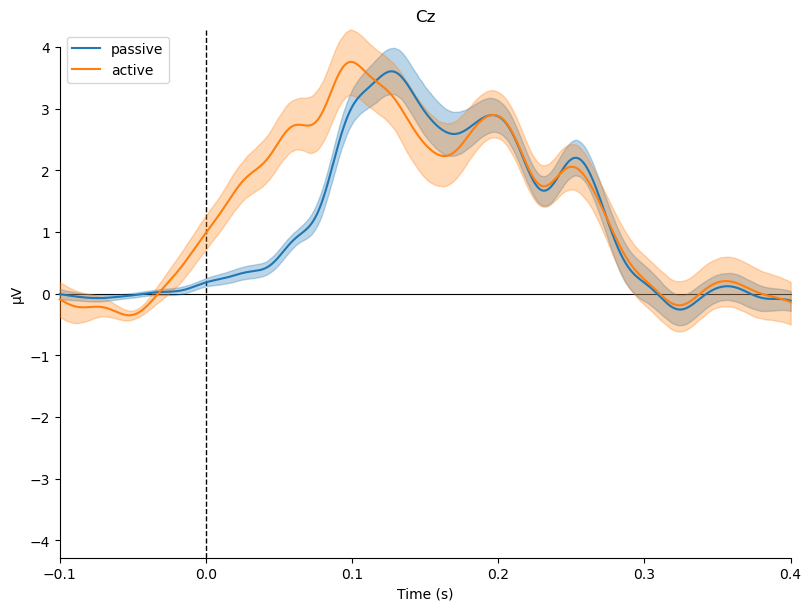

[<Figure size 800x600 with 1 Axes>]

In [27]:
mne.viz.plot_compare_evokeds(evokeds, truncate_xaxis=False, picks='Cz', combine='mean', ci=0.95)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


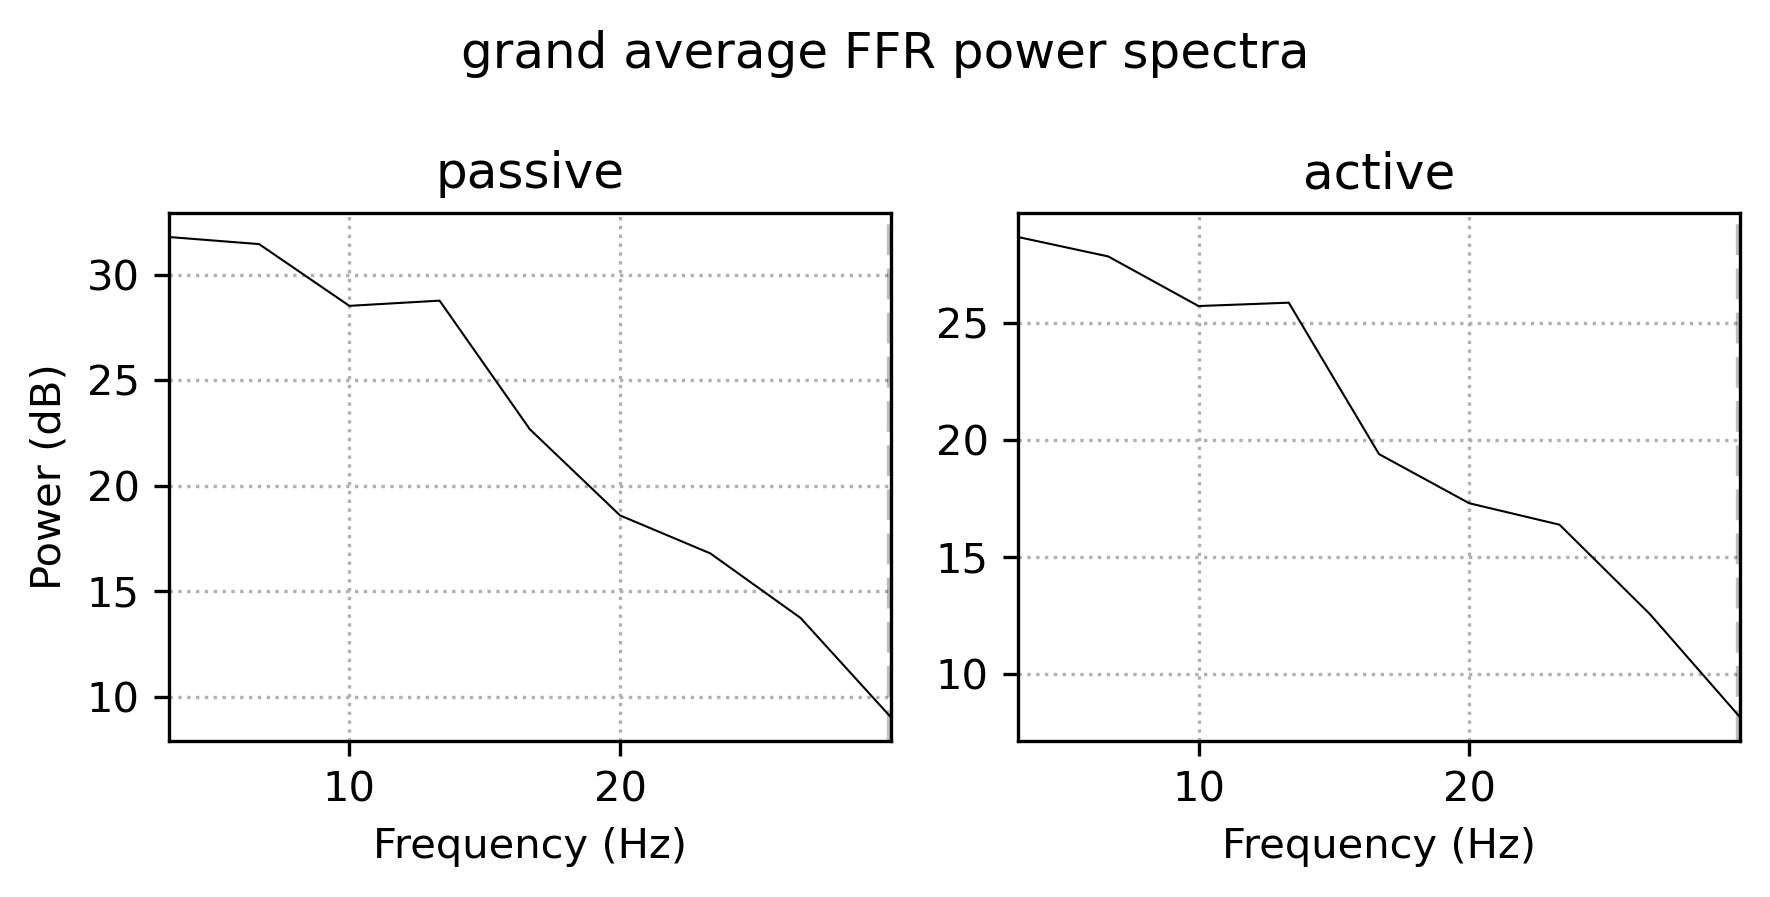

In [ ]:
# Power spectra
passive_psd = passive_grandavg.compute_psd(tmin=0.0, tmax=0.300, fmin=1, fmax=30)
active_psd = active_grandavg.compute_psd(tmin=0.0, tmax=0.300, fmin=1, fmax=30)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=300)
ax = axes.flatten()
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)

ax[0].set_title('passive')
ax[1].set_title('active')

ax[0].set_ylabel('Power (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied


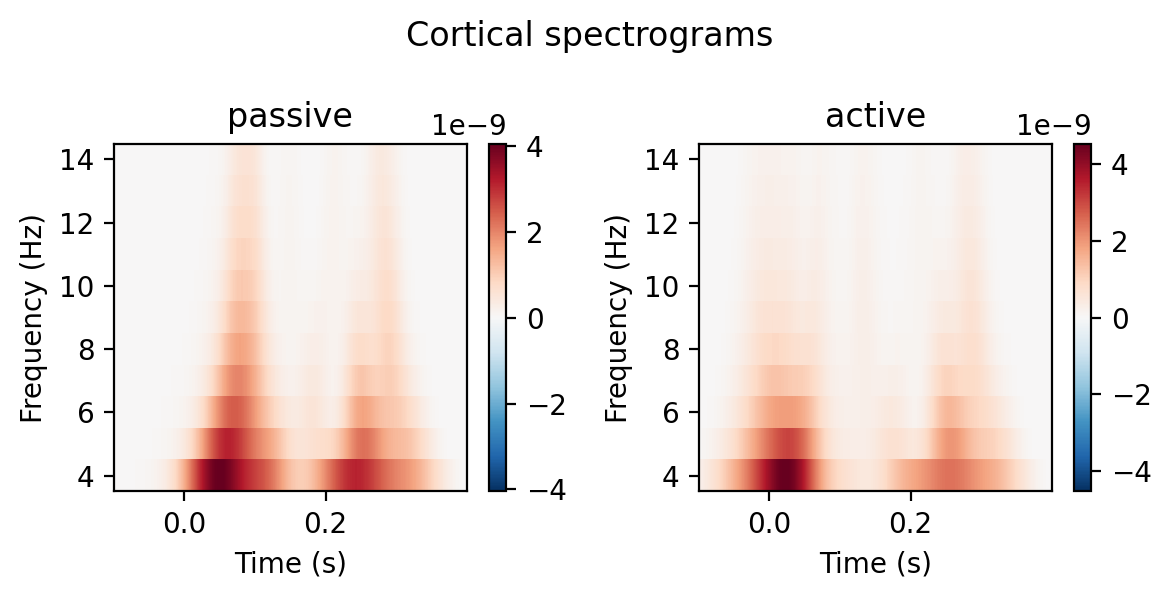

In [113]:
# Spectrograms
frequencies = np.arange(4, 15)

passive_power = passive_grandavg.compute_tfr('multitaper', freqs=frequencies, n_cycles=1)
active_power = active_grandavg.compute_tfr('multitaper', freqs=frequencies, n_cycles=1)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.4, #vlim=[0, 5e-12], 
                   show=False)
active_power.plot(axes=ax[1], tmax=0.4, #vlim=[0, 5e-12], 
                  show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'Cortical spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectrograms.svg')

### Peak stats

In [169]:
f_low=4
f_high=15
t_low=0.1
t_high=0.2

# Extract power for passive condition
pas_peak_lat_list = []
pas_peak_amp_list = []
for evk in passive_avgs:
    peak = evk.get_peak(tmin=0.05, tmax=0.15, return_amplitude=True)
    pas_peak_lat_list.append(peak[1])
    pas_peak_amp_list.append(peak[2])

# Extract power for active condition
act_peak_lat_list = []
act_peak_amp_list = []
for evk in active_avgs:
    peak = evk.get_peak(tmin=0.05, tmax=0.15, return_amplitude=True)
    act_peak_lat_list.append(peak[1])
    act_peak_amp_list.append(peak[2])

# Create a DataFrame for power values
peak_lat_dict = {'passive': pas_peak_lat_list,  
              'active': act_peak_lat_list}
peak_df = pd.DataFrame(peak_lat_dict)

In [166]:
passive_avgs[0].pick('Cz').get_peak()

('Cz', 0.13323974609375)

In [170]:
peak_df

,passive,active
0,0.133240,0.105347
1,0.129822,0.137329
2,0.097717,0.097107
3,0.147461,0.144775
4,0.114136,0.085938
5,0.111755,0.103271
6,0.125610,0.093994
7,0.122009,0.125610
8,0.132874,0.098755
9,0.105347,0.101379


In [ ]:
# Compute the mean peak for each condition
peak_pass_mean = peak_df['passive'].mean()
peak_act_mean = peak_df['active'].mean()
print(f'Mean passive peak latency: {peak_pass_mean:.03f} ms')
print(f'Mean active peak latency: {peak_act_mean:.03f} ms')

# Perform paired t-test
t_stat, p_value = ttest_rel(peak_df['passive'], peak_df['active'])
print(f"peak t-statistic: {t_stat:.03f}, peak p-value: {p_value:.05f}")

Mean passive peak latency: 0.123
Mean active peak latency: 0.099
peak t-statistic: 4.992, peak p-value: 0.00003


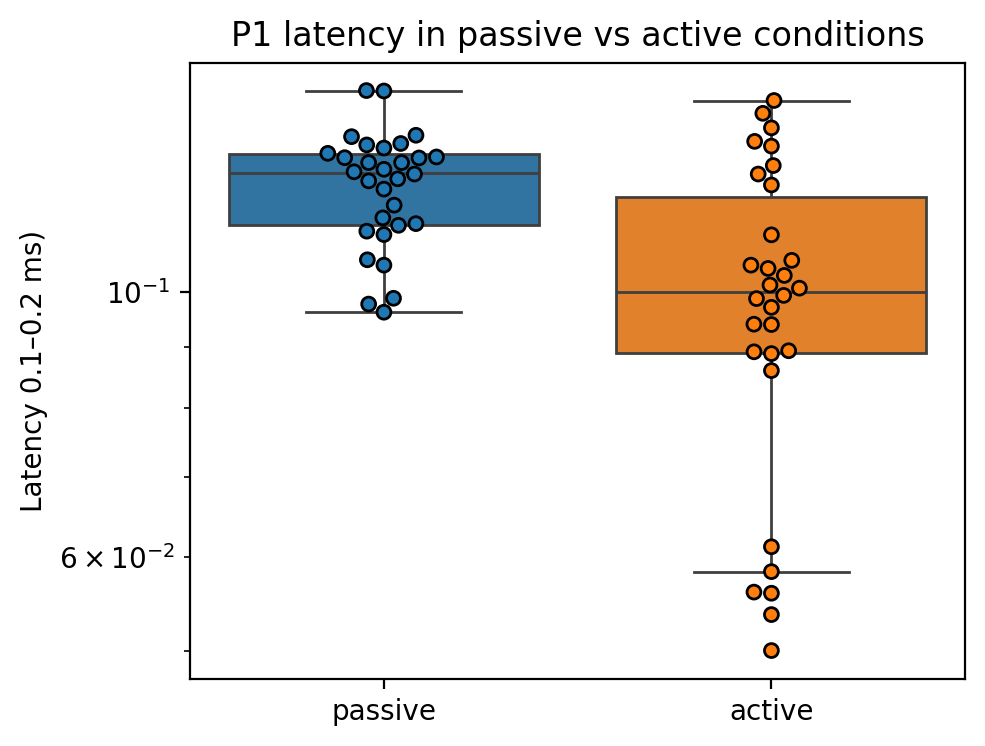

In [172]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(peak_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(peak_df, fliersize=0)
plt.ylabel(f'Latency {t_low}–{t_high} ms)')
plt.title('P1 latency in passive vs active conditions')
plt.show()

### Power stats

In [ ]:
def compute_power(avg_evoked, f_low=90, f_high=110, t_low=0.1, t_high=0.2):
    # Compute the spectrogram (time-frequency representation)
    power = mne.time_frequency.tfr_multitaper(avg_evoked, 
                                            freqs=np.arange(f_low, f_high, 1), 
                                            n_cycles=2, 
                                            time_bandwidth=4.0,
                                            average=True, 
                                            return_itc=False)

    # Select the time and frequency bands
    time_mask = (power.times >= t_low) & (power.times <= t_high)
    freq_mask = (power.freqs >= f_low) & (power.freqs <= f_high)

    # Extract the power within the specified bands
    selected_power = power.data[:, freq_mask, :][:, :, time_mask]

    # Average power over the selected time and frequency bands
    average_power = selected_power.mean(axis=2).mean(axis=1)[0]
    return average_power

#### motor response

In [179]:
f_low=4
f_high=30
t_low=-0.04
t_high=0.1

# Extract power for passive condition
pas_power_list = []
for evk in passive_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in active_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

In [180]:
# check the power dataframe
power_df.head()

,passive,active
0,1.520355e-09,7.119083e-10
1,3.017907e-09,4.923955e-09
2,4.682484e-10,1.017303e-09
3,1.009315e-09,1.964498e-09
4,1.948993e-10,4.973715e-09


In [181]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.05f}")

Mean passive power: 1.039281908282596e-09
Mean active power: 1.6644402847889267e-09
power t-statistic: -2.775, p-value: 0.00955


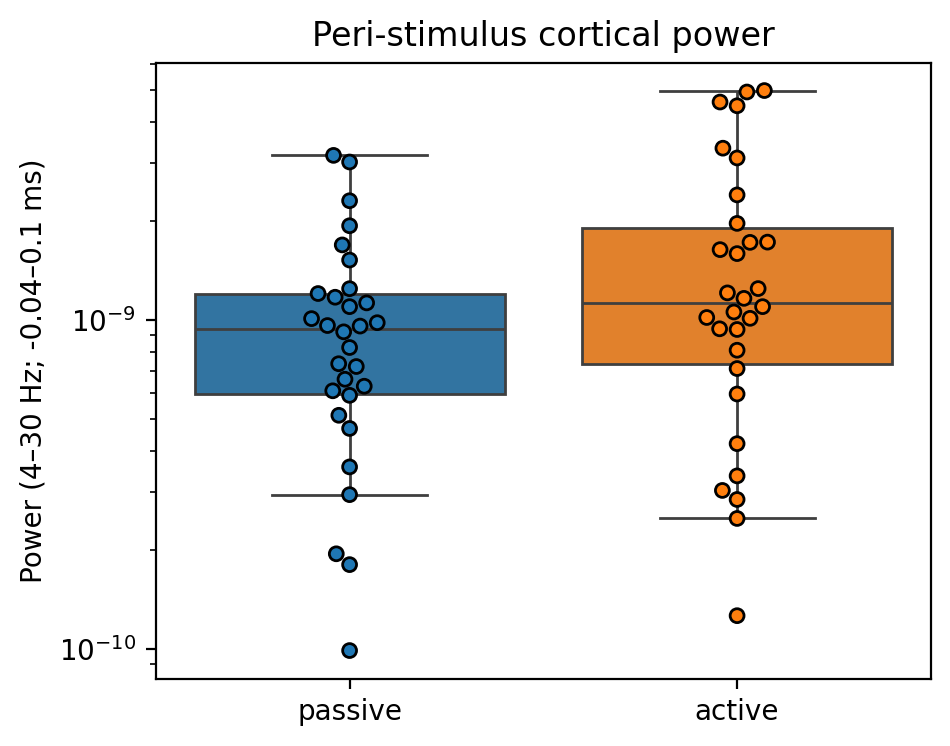

In [183]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel(f'Power ({f_low}–{f_high} Hz; {t_low}–{t_high} ms)')
plt.title('Peri-stimulus cortical power')
plt.show()

#### FFR range

In [175]:
f_low=4
f_high=15
t_low=0.1
t_high=0.2

# Extract power for passive condition
pas_power_list = []
for evk in passive_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in active_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

In [176]:
# check the power dataframe
power_df.head()

,passive,active
0,3.380894e-09,1.055719e-09
1,4.870672e-09,7.311299e-09
2,7.454809e-10,1.360379e-09
3,2.180990e-09,1.965257e-09
4,7.484531e-10,6.248776e-09


In [177]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive power: 2.016292519175918e-09
Mean active power: 2.4716928490160453e-09
power t-statistic: -1.373, p-value: 0.180


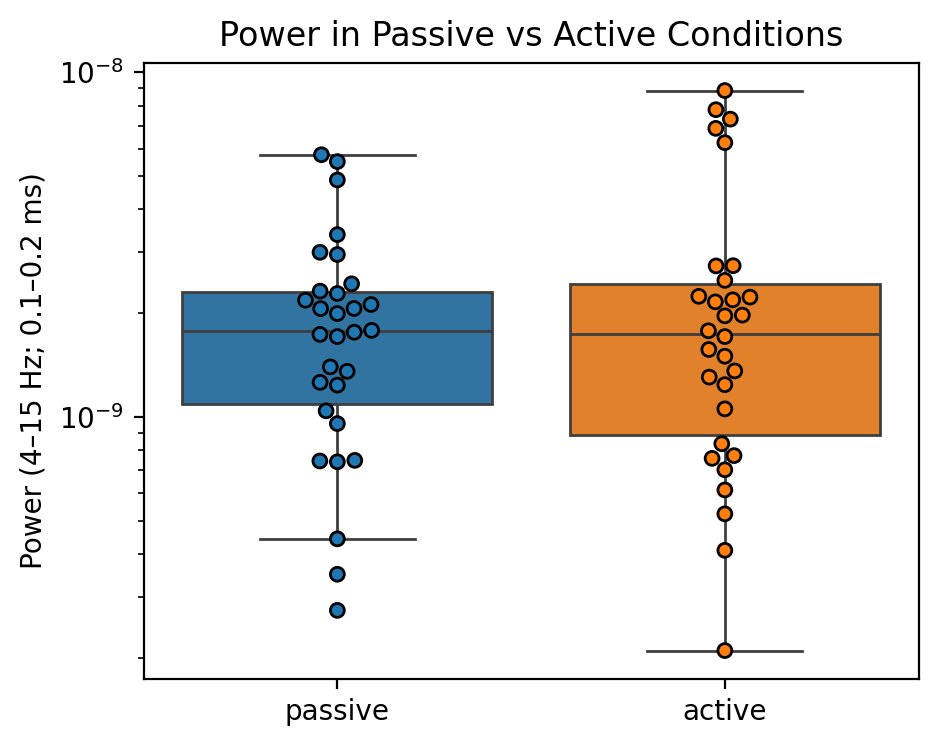

In [178]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel(f'Power ({f_low}–{f_high} Hz; {t_low}–{t_high} ms)')
plt.title('Power in Passive vs Active Conditions')
plt.show()

#### Whole epoch

In [114]:
f_low=4
f_high=30
t_low=-0.04
t_high=0.4

# Extract power for passive condition
pas_power_list = []
for evk in pas_pos_avgs+pas_neg_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in act_pos_avgs+act_neg_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

In [116]:
# check the power dataframe
power_df.head()

,passive,active
0,1.490847e-09,6.820746e-10
1,2.299079e-09,3.859819e-09
2,4.732476e-10,6.723720e-10
3,9.620821e-10,1.243932e-09
4,4.734627e-10,3.374936e-09


In [117]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive power: 9.8389051037912e-10
Mean active power: 1.3151108656612673e-09
power t-statistic: -3.247, p-value: 0.002


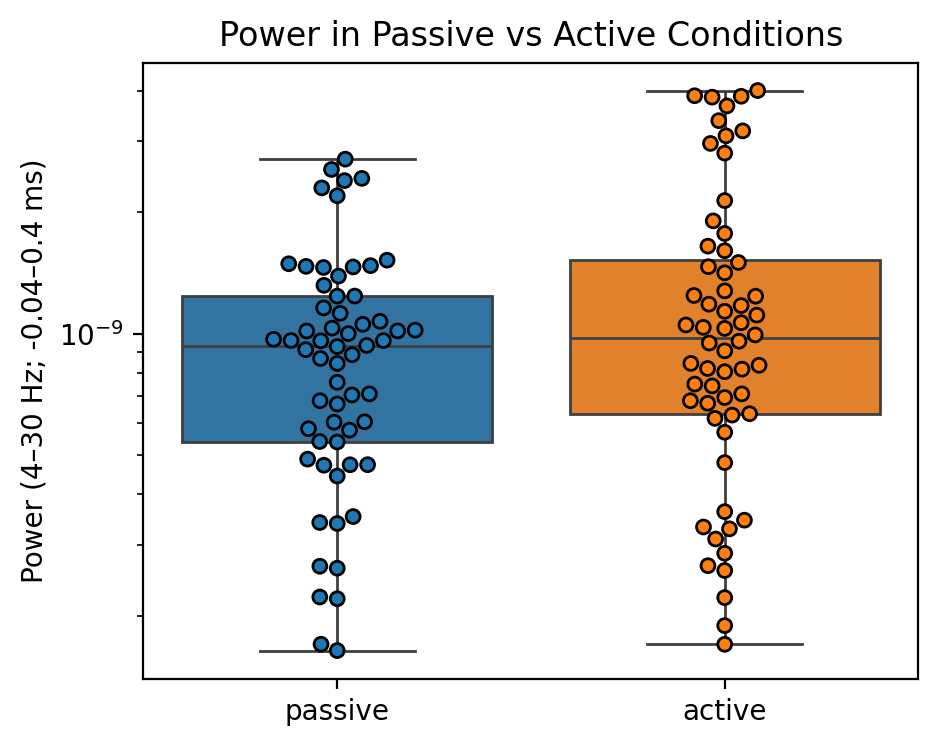

In [118]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel(f'Power ({f_low}–{f_high} Hz; {t_low}–{t_high} ms)')
plt.title('Power in Passive vs Active Conditions')
plt.show()

#### Alpha band

In [146]:
f_low=8
f_high=12
t_low=-0.04
t_high=0.4

# Extract power for passive condition
pas_power_list = []
for evk in passive_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in active_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

In [147]:
# check the power dataframe
power_df.head()

,passive,active
0,1.922648e-09,9.235740e-10
1,3.085528e-09,4.964436e-09
2,6.342311e-10,1.047460e-09
3,1.240995e-09,1.657490e-09
4,6.263974e-10,4.778415e-09


In [148]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive power: 1.3185641767728382e-09
Mean active power: 1.76637199585059e-09
power t-statistic: -2.268, p-value: 0.031


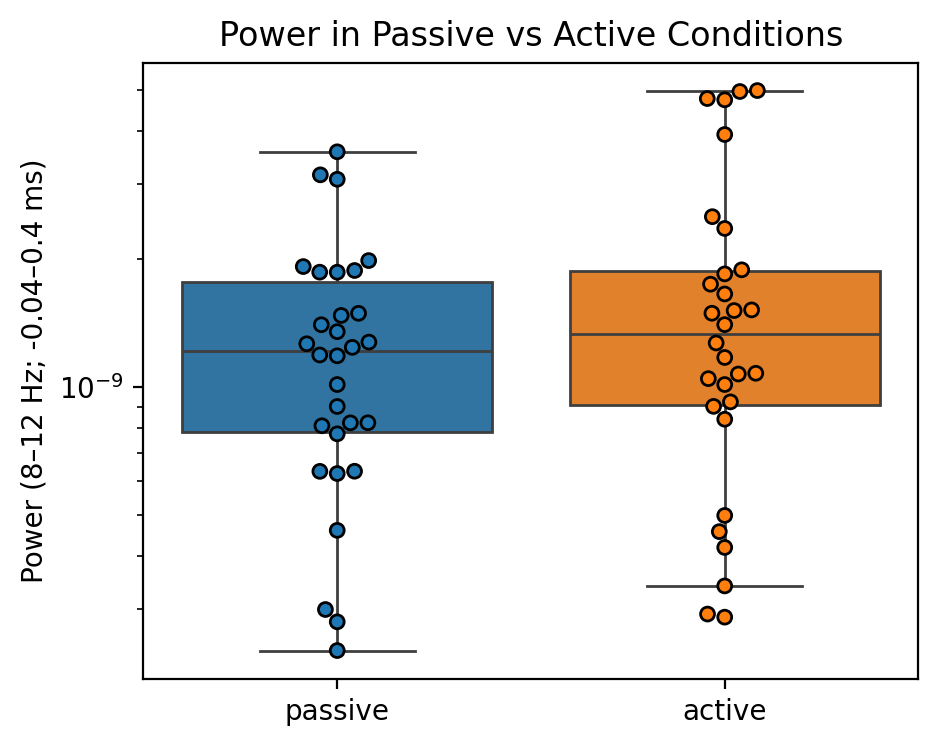

In [149]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel(f'Power ({f_low}–{f_high} Hz; {t_low}–{t_high} ms)')
plt.title('Power in Passive vs Active Conditions')
plt.show()

### RMS SNR

In [45]:
from numpy import mean, sqrt, square

In [46]:
task_evoked_dict = {}
task_evoked_dict['passive'] = passive_grandavg
task_evoked_dict['active']  = active_grandavg

In [47]:
for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    baseline_ind_bounds = s_evoked.time_as_index(task_evoked_dict[stim].baseline)
    response_ind_bounds = s_evoked.time_as_index([0.100, 0.300])

    evoked_baseline = s_evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = s_evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline

    print(f'{stim} RMS SNR: {rms_snr:.04f}')


passive RMS SNR: 39.4038
active RMS SNR: 6.5082


In [52]:
print('peri-stimulus RMS SNRs')
for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    baseline_ind_bounds = s_evoked.time_as_index(task_evoked_dict[stim].baseline)
    response_ind_bounds = s_evoked.time_as_index([0.0, 0.100])

    evoked_baseline = s_evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = s_evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline

    print(f'{stim} response RMS: {rms_response:.08f}')
    print(f'{stim} baseline RMS: {rms_baseline:.08f}')

    print(f'{stim} RMS SNR: {rms_snr:.04f}')


peri-stimulus RMS SNRs
passive response RMS: 0.00000123
passive baseline RMS: 0.00000006
passive RMS SNR: 19.1136
active response RMS: 0.00000250
active baseline RMS: 0.00000037
active RMS SNR: 6.7382


## Individual polarities

In [91]:
ind_evokeds = dict(passive_pos=pas_pos_avgs,
                   passive_neg=pas_neg_avgs, 
                   active_pos=act_pos_avgs,
                   active_neg=act_neg_avgs)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_31413/1134780631.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(ind_evokeds,


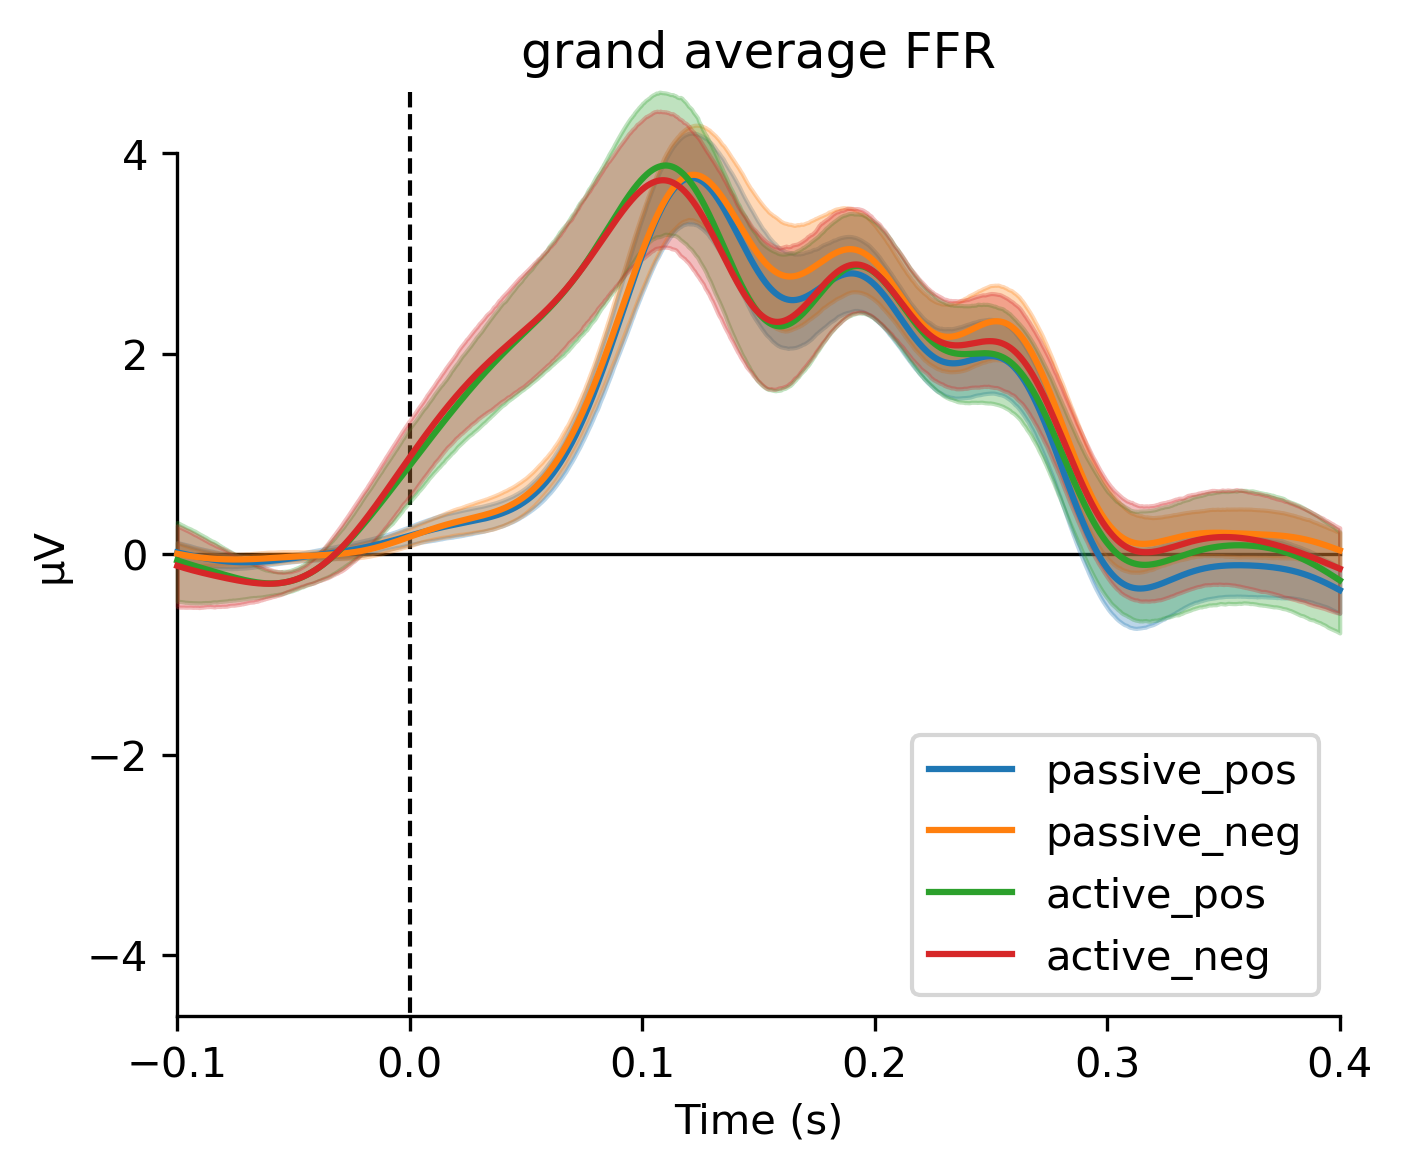

[<Figure size 1500x1200 with 1 Axes>]

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300)
#ax.legend(['passive/positive', 'passive/negative', 'active/positive', 'active/negative'], 
#          loc="upper right")
mne.viz.plot_compare_evokeds(ind_evokeds,
                             legend='lower right',
                             title='grand average FFR',
                             truncate_xaxis=False,
                             axes=ax)

Text(0.5, 1.0, 'active/negative')

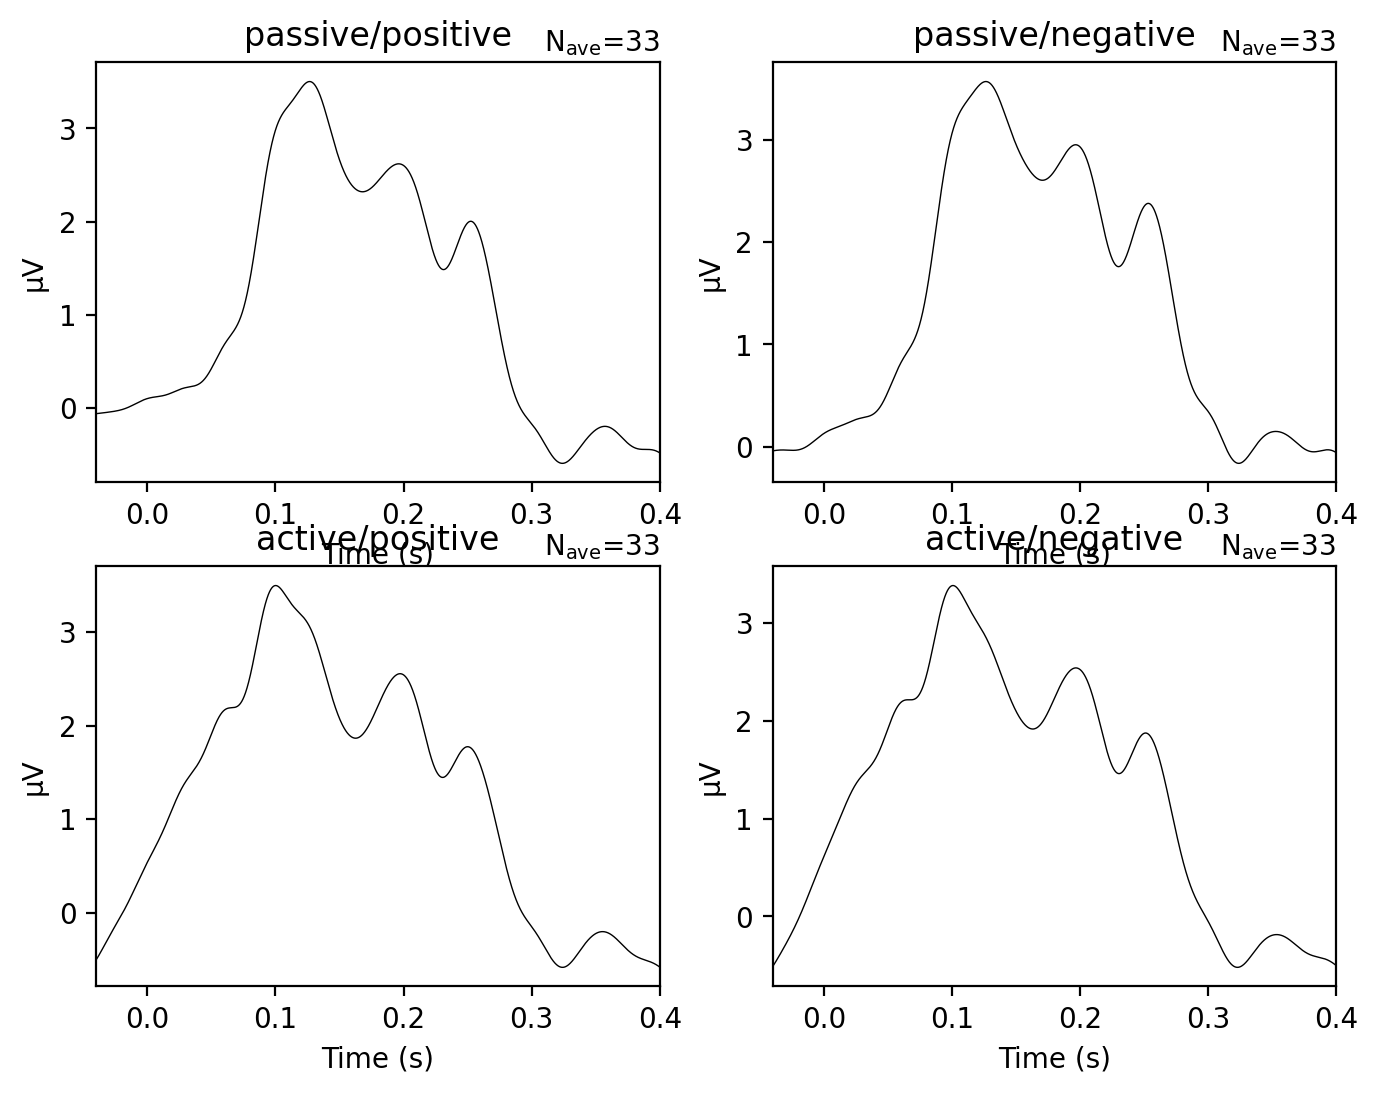

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
pas_pos_grandavg.plot(axes=ax[0], selectable=False, show=False)
pas_neg_grandavg.plot(axes=ax[1], selectable=False, show=False)
act_pos_grandavg.plot(axes=ax[2], selectable=False, show=False)
act_neg_grandavg.plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

In [ ]:
# Power spectra
passive_pos_psd = pas_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
passive_neg_psd = pas_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_pos_psd = act_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_neg_psd = act_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

In [ ]:
# Spectrograms
passive_pos_power = pas_pos_grandavg.compute_tfr(method="", freqs=frequencies)
passive_neg_power = pas_neg_grandavg.compute_tfr("morlet", freqs=frequencies)
active_pos_power  = act_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
active_neg_power  = act_neg_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], tmax=0.4, vlim=[0, 5e-12], show=False)
passive_neg_power.plot(axes=ax[1], tmax=0.4, vlim=[0, 5e-12], show=False)
active_pos_power.plot(axes=ax[2], tmax=0.4, vlim=[0, 5e-12], show=False)
active_neg_power.plot(axes=ax[3], tmax=0.4, vlim=[0, 5e-12], show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')